In [12]:
from selenium import webdriver
from selenium .webdriver.chrome.service import Service
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium import webdriver
from tqdm.notebook import tqdm
import re
import pandas as pd
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import numpy as np
import seaborn as sns
import koreanize_matplotlib
#Font -> koreanize_matplotlib doesn't work in my environment
#font_path = 'C:/Windows/Fonts/gulim.ttc'
#font_name = fm.FontProperties(fname=font_path).get_name()
#plt.rc('font', family=font_name) 

### Open Website

In [14]:
url = "https://www.applyhome.co.kr/co/coa/selectMainView.do"
driver = webdriver.Chrome(service = Service('../../driver/chromedriver-linux64/chromedriver'))
driver.get(url)
click_data = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="gnb"]/li[6]/a'))) # wait until page is loaded. 
driver.set_window_size(1500, 768)
WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="gnb"]/li[6]/a')))
click_data.click()
click_data2 = driver.find_element(By.XPATH, '//*[@id="menu650"]')
driver.execute_script("arguments[0].click();", click_data2)

### Set date & area

In [15]:
search_div = driver.find_element(By.CLASS_NAME, 'search_wrap')

startYear = search_div.find_element(By.ID, "start_year")
year_option = startYear.find_elements(By.TAG_NAME, "option")[12].get_attribute("innerHTML")
startYear.send_keys(year_option)

endYear = search_div.find_element(By.ID, "end_year")
year_option = startYear.find_elements(By.TAG_NAME, "option")[1].get_attribute("innerHTML")
endYear.send_keys(year_option)

# search 'seoul' 
area_select = driver.find_element(By.ID, 'cate02') 
area_option = area_select.find_elements(By.TAG_NAME, "option")[9].get_attribute("innerHTML")
area_select.send_keys(area_option)

# click btn
search_btn = search_div.find_element(By.CLASS_NAME, 'search_btn')
search_btn.click()


### Get each information (Main Code)

In [16]:
#<PAGE 1> 
info_div = driver.find_element(By.CLASS_NAME, 'mt_10')
info_trs = info_div.find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr") # each row = area, apartment name, company etc
area_list = []
houseName_list = []
buildCompnay_list = []
compNum_list = []
applyDate_list = []
address_list = []
price_list = []

df_list = []
cnt = 0

while True:
    ### update rows every page
    info_div = driver.find_element(By.CLASS_NAME, 'mt_10')
    info_trs = info_div.find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr") # each row = area, apartment name, company etc
    page_as = driver.find_element(By.ID, "paging").find_elements(By.TAG_NAME, 'a')  
    ### <Get each apartment's info> ### -> NP 
    for each in info_trs: 
        info_tds = each.find_elements(By.TAG_NAME,"td") # each td -> area, apartment name, company name etc.
        area_list.append(info_tds[0].text)
        houseName_list.append(info_tds[3].text) # info_tds[3]  -> aprtment name. contains detailed info
        buildCompnay_list.append(info_tds[4].get_attribute("innerHTML"))
        compNum_list.append(re.search(r"\d+-\d+(-\d+)?", info_tds[5].find_element(By.TAG_NAME,'a').text).group())
        applyDate_list.append(info_tds[7].text)
       
        ### <click each apartment> -> NP 
        clickApartment = info_tds[3].find_element(By.TAG_NAME, "a") # info_tds[3] -> apartment name
        #clickApartment.click()
        driver.execute_script("arguments[0].click();", clickApartment)
        #----------------------------------------------------------------------------
        ### <clicked, information up. Change to iframe> 
        driver.switch_to.frame("iframeDialog")
        iframe_div = driver.find_element(By.ID, "printArea")
        ###<Get basic infos>  -> NP
        basicInfo_trs = iframe_div.find_element(By.CLASS_NAME, "tbl_st.tbl_normal.tbl_center").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")
        address_list.append(basicInfo_trs[0].find_elements(By.TAG_NAME,"td")[1].text) # 0 <tr location> 1 <tr size>  -> 0 <td location> 1 <td seoul 289-54>
        #----------------------------------------------------------------------------
        ### <Get each apartment's average sale price> :  ### add each model's sale price and find average pric of it. 
        otherInfo_tables = iframe_div.find_elements(By.CLASS_NAME, "tbl_st.tbl_row.tbl_col.tbl_center")
        if len(otherInfo_tables) == 5:
            # 4th table contains sale price. 0<table schedule> 1 <table supplara>  2<special supply> 3 <price>
            salePrice_trs = otherInfo_tables[3].find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr") 
        elif len(otherInfo_tables) == 4: # No special supply
            salePrice_trs = otherInfo_tables[2].find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr") 
        print("apartment models : <average sale price> : " + str(len(salePrice_trs)))
        price_list2 = []
        for each in salePrice_trs: ### each row =  'apartment model' , 'sale price' 'extra' 
            price = each.find_elements(By.TAG_NAME, "td")[1].get_attribute("innerHTML").replace(',','') # 0 <td model> 1 <td price> 88,230
            price = float(price)  * 10000 # unit : 10000 won 
            price_list2.append(price)
        price_list.append(np.mean(price_list2))
        driver.switch_to.default_content()
         #----------------------------------------------------------------------------
        ### close   
        x_btn = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, "ui-button.ui-corner-all.ui-widget.ui-button-icon-only.ui-dialog-titlebar-close")))
        x_btn.click()
    df = pd.DataFrame({"지역": area_list, "주택명" : houseName_list, "시공사" : buildCompnay_list, 
                       "문의처": compNum_list, "청약기간" : applyDate_list, "위치" : address_list, "평균 분양가" : price_list})
    df_list.append(df)
    area_list = []
    houseName_list = []
    buildCompnay_list = []
    compNum_list = []
    applyDate_list = []
    address_list = []
    price_list = []
    cnt+=1
    if (cnt==len(page_as)) : break
    else : 
        page_as[cnt].click()
apartment_df = pd.concat(df_list)
    
   


apartment models : <average sale price> : 3
apartment models : <average sale price> : 3
apartment models : <average sale price> : 4
apartment models : <average sale price> : 8
apartment models : <average sale price> : 7
apartment models : <average sale price> : 8
apartment models : <average sale price> : 6
apartment models : <average sale price> : 6
apartment models : <average sale price> : 2
apartment models : <average sale price> : 5
apartment models : <average sale price> : 9
apartment models : <average sale price> : 5
apartment models : <average sale price> : 18
apartment models : <average sale price> : 15
apartment models : <average sale price> : 8
apartment models : <average sale price> : 5
apartment models : <average sale price> : 5
apartment models : <average sale price> : 5
apartment models : <average sale price> : 2
apartment models : <average sale price> : 8
apartment models : <average sale price> : 6
apartment models : <average sale price> : 4
apartment models : <average sa

### ~구 추출

In [9]:
#apartment_df print (each)
apartment_df["구"]= apartment_df["위치"].str.extract('([가-힣]+구)')
apartment_df

,지역,주택명,시공사,문의처,청약기간,위치,평균 분양가,구
0,서울,더샵 둔촌포레,(주)포스코이앤씨,02-478-8878,2024-03-11 ~ 2024-03-13,서울특별시 강동구 둔촌동 30-4번지 외 1필지,1.485400e+09,강동구
1,서울,에스아이팰리스 올림픽공원,에스테크건설 주식회사,02-486-4388,2024-03-04 ~ 2024-03-06,서울특별시 강동구 성내동 459-3,1.236667e+09,강동구
2,서울,경희궁 유보라,(주)반도건설,1661-0161,2024-03-04 ~ 2024-03-06,서울특별시 서대문구 영천동 69-20외 160필지,1.271250e+09,서대문구
3,서울,메이플자이,지에스건설 주식회사,1833-2566,2024-02-05 ~ 2024-02-08,서울특별시 서초구 잠원동 60-3,1.498500e+09,서초구
4,서울,포제스 한강,디엘이앤씨(주),1899-7099,2024-01-24 ~ 2024-01-26,서울특별시 광진구 광장동 188-2번지 일원,1.048571e+10,광진구
5,서울,어반클라쎄목동,"한바로이앤씨(주), 아하건설(주)",02-6101-0808,2023-12-29 ~ 2024-01-02,"서울특별시 양천구 신목로2길 7-12 (신정동, 어반클라쎄 목동)",9.359375e+08,양천구
6,서울,에스아이팰리스 강동 센텀Ⅱ,(주)이엔건설,02-486-4386,2023-12-26 ~ 2023-12-28,"서울특별시 강동구 길동 386-4 (길동, 에스아이팰리스 강동 센텀2)",5.421667e+08,강동구
7,서울,청계리버뷰자이,지에스건설 주식회사,1833-7244,2023-12-11 ~ 2023-12-13,서울특별시 성동구 용답동 108-1번지 일원,1.144400e+09,성동구
8,서울,삼익 더 랩소디,(주)세담종합건설,1599-9807,2023-12-07 ~ 2023-12-08,서울특별시 강서구 강서로 353 (내발산동),1.075000e+09,강서구
9,서울,마포 푸르지오 어반피스,(주)대우건설,02-538-0122,2023-12-04 ~ 2023-12-06,서울특별시 마포구 아현동 613-10번지 일원,1.313680e+09,마포구


### 시각화 (어떤 서울시 구의 청약 주택 평균 분양가가 더 높은가?) 

/tmp/ipykernel_14333/3874133044.py:1: FutureWarning: The provided callable <function mean at 0x7f5f101a0f70> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  gu_df = pd.pivot_table(data=apartment_df, index = '구', values = '평균 분양가', aggfunc=np.mean)
/tmp/ipykernel_14333/3874133044.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='구', y='평균 분양가', data=gu_df,  palette= 'bright')
/home/jy/venv/eda_venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jy/venv/eda_venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DON

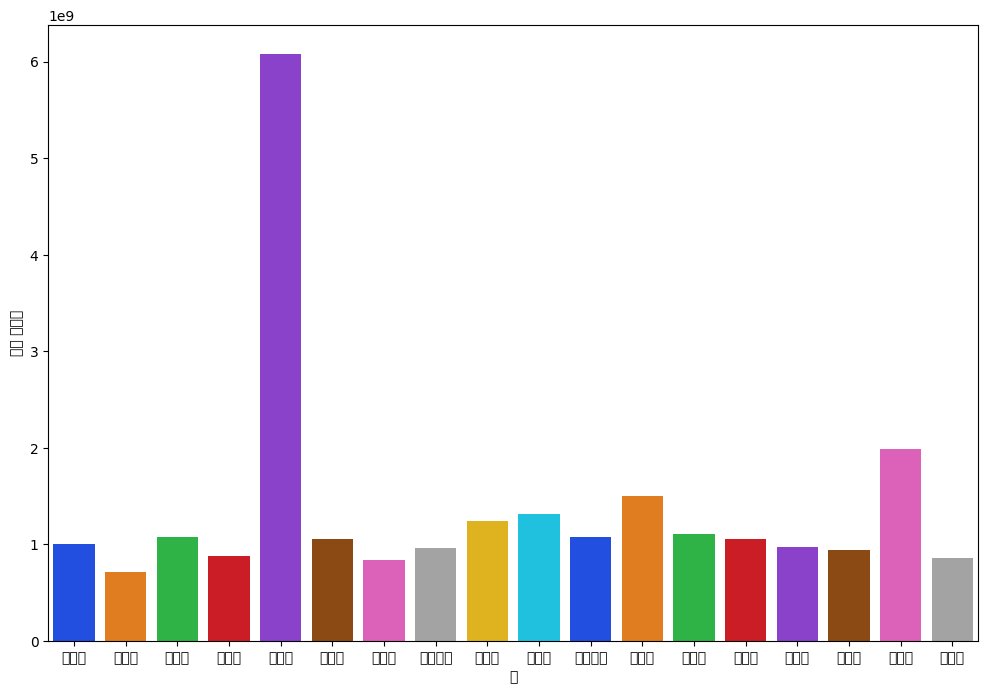

,지역,주택명,시공사,문의처,청약기간,위치,평균 분양가,구
4,서울,포제스 한강,디엘이앤씨(주),1899-7099,2024-01-24 ~ 2024-01-26,서울특별시 광진구 광장동 188-2번지 일원,1.048571e+10,광진구
6,서울,용산 호반써밋 에이디션,(주)호반건설,1670-6207,2023-07-24 ~ 2023-07-27,서울특별시 용산구 한강로 2가 210-1번지 일원,1.981700e+09,용산구
4,서울,롯데캐슬 이스트폴,롯데건설(주),1533-1616,2023-07-31 ~ 2023-08-02,서울특별시 광진구 자양동 680-63번지 일원,1.669091e+09,광진구
3,서울,메이플자이,지에스건설 주식회사,1833-2566,2024-02-05 ~ 2024-02-08,서울특별시 서초구 잠원동 60-3,1.498500e+09,서초구
0,서울,더샵 둔촌포레,(주)포스코이앤씨,02-478-8878,2024-03-11 ~ 2024-03-13,서울특별시 강동구 둔촌동 30-4번지 외 1필지,1.485400e+09,강동구
9,서울,마포 푸르지오 어반피스,(주)대우건설,02-538-0122,2023-12-04 ~ 2023-12-06,서울특별시 마포구 아현동 613-10번지 일원,1.313680e+09,마포구
2,서울,경희궁 유보라,(주)반도건설,1661-0161,2024-03-04 ~ 2024-03-06,서울특별시 서대문구 영천동 69-20외 160필지,1.271250e+09,서대문구
5,서울,더샵 강동센트럴시티,(주)포스코이앤씨,1661-2001,2023-10-16 ~ 2023-10-18,서울특별시 강동구 천호동 410-100번지 일원,1.262800e+09,강동구
0,서울,상도 푸르지오 클라베뉴,대우건설,02-575-0771,2023-09-04 ~ 2023-09-06,서울특별시 동작구 상도동 산65-74 번지 일원,1.238873e+09,동작구
1,서울,에스아이팰리스 올림픽공원,에스테크건설 주식회사,02-486-4388,2024-03-04 ~ 2024-03-06,서울특별시 강동구 성내동 459-3,1.236667e+09,강동구


In [10]:
gu_df = pd.pivot_table(data=apartment_df, index = '구', values = '평균 분양가', aggfunc=np.mean)
gu_df
plt.figure(figsize=(12,8))
sns.barplot(x='구', y='평균 분양가', data=gu_df,  palette= 'bright')
plt.show()

apartment_df.sort_values(by="평균 분양가", ascending = False).head(10)

### 포제스 한강 이상치로 제외 (평균가 100억..)

/tmp/ipykernel_14333/3539134122.py:4: FutureWarning: The provided callable <function mean at 0x7f5f101a0f70> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  gu_df2 = pd.pivot_table(data=apartment_df2, index = '구', values = '평균 분양가', aggfunc=np.mean)
/tmp/ipykernel_14333/3539134122.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='구', y='평균 분양가', data=gu_df2,  palette= 'bright')


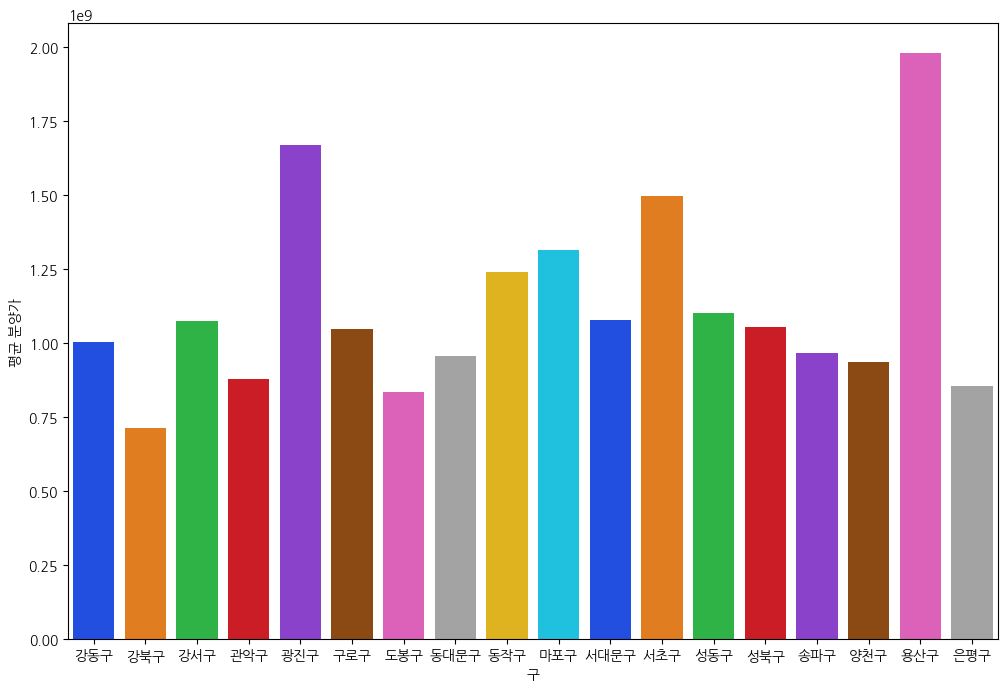

In [13]:
apartment_df2 = apartment_df[apartment_df["주택명"]!="포제스 한강"]
apartment_df2.sort_values(by="평균 분양가", ascending=False)

gu_df2 = pd.pivot_table(data=apartment_df2, index = '구', values = '평균 분양가', aggfunc=np.mean)
plt.figure(figsize=(12,8))
sns.barplot(x='구', y='평균 분양가', data=gu_df2,  palette= 'bright')
plt.show()